# Use Case Description
Forecasting internet traffic is a critical use case for network operators and service providers, enabling them to proactively manage and optimize their infrastructure. By analyzing historical data and applying predictive analytics, organizations can anticipate future traffic demands, identify potential bottlenecks, and strategically allocate resources. This foresight allows for efficient capacity planning, ensuring sufficient bandwidth and hardware are available to meet user needs, prevent network congestion, and maintain high service quality. Furthermore, accurate traffic forecasts aid in detecting anomalies, optimizing routing paths, and scheduling maintenance during periods of low usage, ultimately leading to improved operational efficiency, reduced costs, and enhanced customer satisfaction.

# Dataset
The **../sample_data/internet_traffic.csv** dataset is used in this example, which is available under the data directory of this repo. It is also built in as a sample dataset in Splunk AI Toolkit. The dataset contains a field _time spanning from 2005-06-07 23\:00\:00 to 2005-07-29 05\:55\:00 with 5-minute interval and a field bits_transferred containing amount of bits transferred during the period.

# Forecasting
In this example, we showcase how to use Cisco Time Series Model for internet traffic forecasting based on data from the past month. The historical data points on the time series are first processed into **multi-resolution** (5-minute interval for the latest 512 data points and 5-hour for the data points before), which is showcased in the notebook. With the multi-resolution input, the model forecasts the bits_transferred value of the **next 128 timestamps**, which adds up to about 10 hours into the future.


# About this notebook
This notebook contains 6 stages to help users understand how to use the model:
* Stage 1: Import libraries and utilities
* Stage 2: Load the dataset and Visualize raw time series data
* Stage 3: Visualization on the Multi-Resolution Processing
* Stage 4: Load the Cisco Time Series Model
* Stage 5: Forecasting with Ground Truth
* Stage 6: Forecasting on Future States

---
# Stage 1: Import libraries and utilities

Libraries and functions for utilizing the model are imported in the cells below

In [1]:
import sys
from pathlib import Path

if "__file__" in globals():
    base_dir = Path(__file__).resolve().parent
else:
    base_dir = Path.cwd()

parent = base_dir.parent
if str(parent) not in sys.path:
	sys.path.insert(0, str(parent))
    
import pandas as pd
import torch
import matplotlib.pyplot as plt

from modeling import CiscoTsmMR, TimesFmHparams, TimesFmCheckpoint

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.
Loaded PyTorch TimesFM, likely because python version is 3.11.10 | packaged by conda-forge | (main, Oct 16 2024, 01:27:36) [GCC 13.3.0].


---
# Stage 2: Load the dataset and Visualize raw time series data

Read dataset from the data/ path and visualize the raw input time series

In [2]:
with open("../sample_data/internet_traffic.csv", 'r') as f:
    df = pd.read_csv(f)
df['_time'] = pd.to_datetime(df['_time'], unit='s')
df = df.set_index('_time')
df

,bits_transferred
_time,
2005-06-07 14:00:00,3397.254111
2005-06-07 14:05:00,3538.337298
2005-06-07 14:10:00,3697.843268
2005-06-07 14:15:00,3696.780082
2005-06-07 14:20:00,4370.253163
...,...
2005-07-12 06:55:00,8144.962705
2005-07-12 07:00:00,8074.665832
2005-07-12 07:05:00,8217.367633


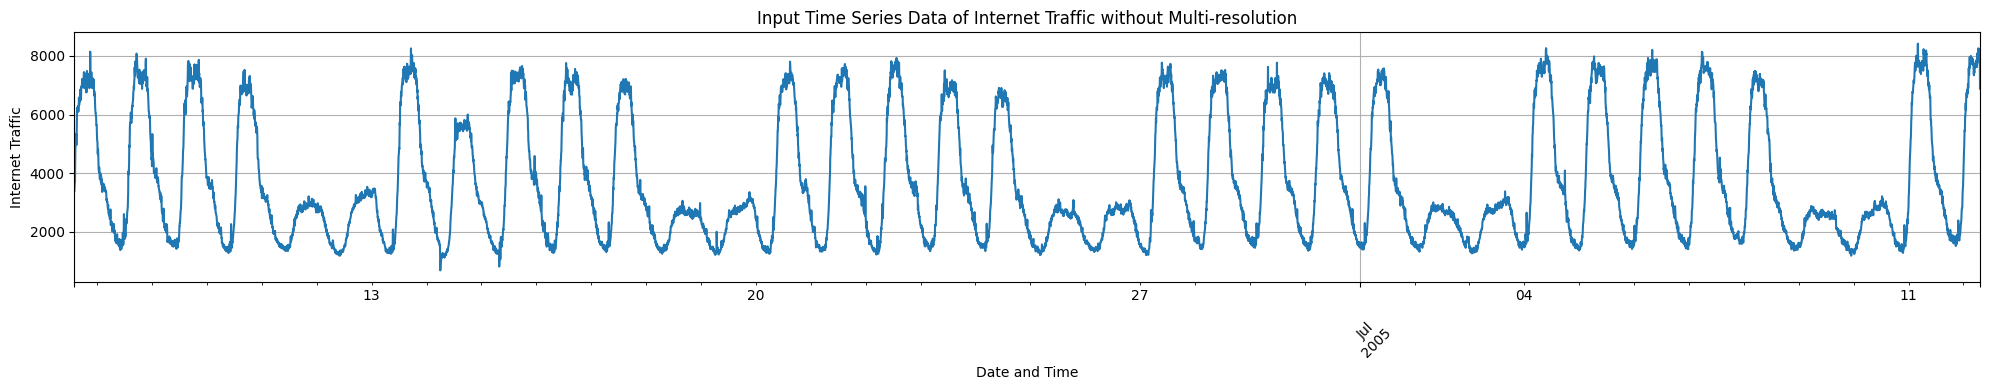

In [3]:
plt.figure(figsize=(20, 4))
df['bits_transferred'].plot(title='Input Time Series Data of Internet Traffic without Multi-resolution', grid=True)
plt.xlabel('Date and Time')
plt.ylabel('Internet Traffic')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

---
# Stage 3: Load the Cisco Time Series Model

Download the model checkpoint from Huggingface.

In [4]:
hp = TimesFmHparams(
	num_layers=50,
	use_positional_embedding=False,
	backend="gpu" if torch.cuda.is_available() else "cpu",
)

# Load model from the Huggingface repo of Cisco Time Series Model
repo_id = "cisco-ai/cisco-time-series-model-1.0-preview"

ckpt = TimesFmCheckpoint(huggingface_repo_id=repo_id)

model = CiscoTsmMR(
    hparams=hp,
    checkpoint=ckpt,
    use_resolution_embeddings=True,
    use_special_token=True,
)

Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

---
# [OPTIONAL] Stage 4: Visualization on the Multi-Resolution Processing 

* The cell below visualizes how multi-resolution processing transforms the input time series, This cell is **ONLY for showcasing purpose**. 
* During inference, the multi-reposution transformation happens automatically.

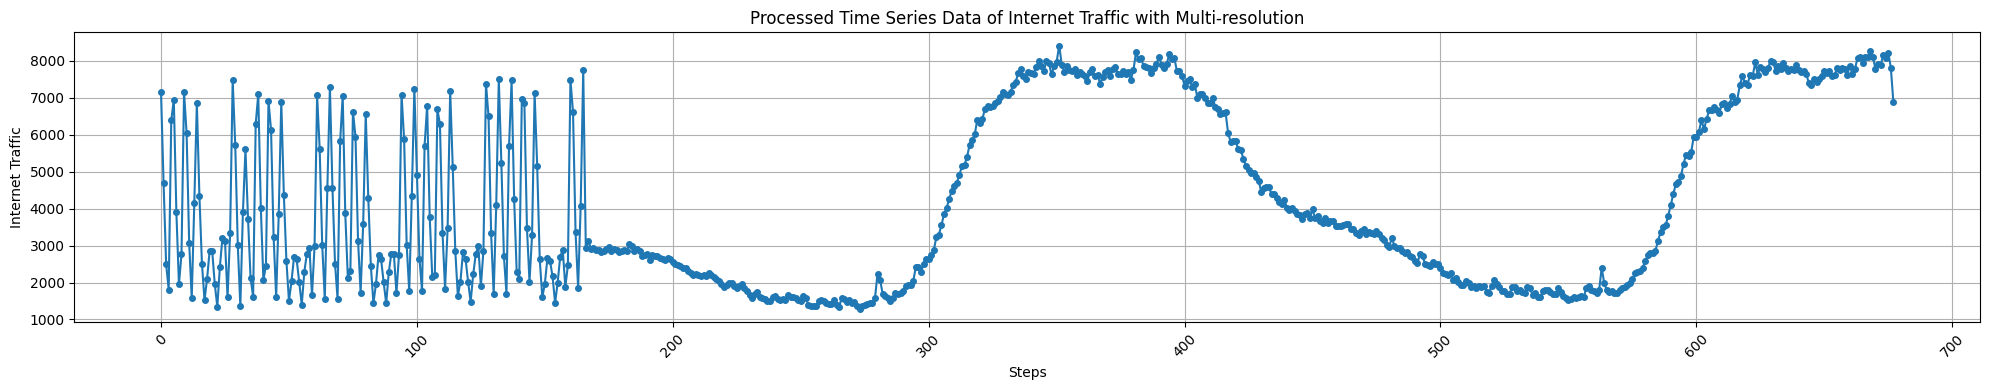

In [5]:
context_1hr, context_1min =  model.build_multi_resolution(df["bits_transferred"].tolist())
processed_series = context_1hr
processed_series.extend(context_1min)

plt.figure(figsize=(20, 4))
plt.plot(list(range(len(processed_series))), processed_series, marker='o', linestyle='-', markersize=4)
plt.title('Processed Time Series Data of Internet Traffic with Multi-resolution')
plt.xlabel('Steps')
plt.ylabel('Internet Traffic')
plt.grid(True)
plt.xticks(rotation=45) 
plt.tight_layout()
plt.show()

---
# Stage 5: Forecasting with Ground Truth

* In order to showcase the model performance, we use the model to forecast the last 128 steps of the known time series and compare with the known values (ground truth) in the time series.
* The model outputs two lists: mean (mean forecasts) and full (quantile forecasts from P10 to P90)

In [6]:
FORECAST_WINDOW = 128

forecasts = model.forecast([df["bits_transferred"].tolist()[:-FORECAST_WINDOW]], horizon_len=FORECAST_WINDOW)

/home/ubuntu/praneet/github/cisco-time-series-model/1.0-preview/modeling/cisco_tsm_mr.py:373: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  batch_coarse = torch.as_tensor(coarse_contexts[start:end],  dtype=torch.float32).unsqueeze(-1).to(self._device)


In [7]:
print("Mean: " + str(forecasts[0]["mean"].shape))
print("Quantile 0.1: " + str(forecasts[0]["quantiles"]["0.1"].shape))

Mean: (128,)
Quantile 0.1: (128,)


In [8]:
# Set ground-truth series for plot
ground_truth = processed_series.copy()
processed_input = processed_series[:-FORECAST_WINDOW]

# Obtain mean and quantiles of the forecasted series
means = processed_input + forecasts[0]["mean"].tolist()
p10 = processed_input + forecasts[0]["quantiles"]["0.1"].tolist() 
p20 = processed_input + forecasts[0]["quantiles"]["0.2"].tolist() 
p30 = processed_input + forecasts[0]["quantiles"]["0.3"].tolist() 
p40 = processed_input + forecasts[0]["quantiles"]["0.4"].tolist() 
p50 = processed_input + forecasts[0]["quantiles"]["0.5"].tolist() 
p60 = processed_input + forecasts[0]["quantiles"]["0.6"].tolist() 
p70 = processed_input + forecasts[0]["quantiles"]["0.7"].tolist() 
p80 = processed_input + forecasts[0]["quantiles"]["0.8"].tolist() 
p90 = processed_input + forecasts[0]["quantiles"]["0.9"].tolist() 

# Put all results into a dataframe
df_plot = pd.DataFrame({
    'Steps': list(range(len(ground_truth))),
    'Ground_Truth': ground_truth,
    'TSFM_Mean': means,
    'TSFM_P10': p10,
    'TSFM_P20': p20,
    'TSFM_P30': p30,
    'TSFM_P40': p40,
    'TSFM_P50': p50,
    'TSFM_P60': p60,
    'TSFM_P70': p70,
    'TSFM_P80': p80,
    'TSFM_P90': p90,
})

df_plot.set_index('Steps')

,Ground_Truth,TSFM_Mean,TSFM_P10,TSFM_P20,TSFM_P30,TSFM_P40,TSFM_P50,TSFM_P60,TSFM_P70,TSFM_P80,TSFM_P90
Steps,,,,,,,,,,,
0,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162
1,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228
2,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360
3,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715
4,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652
...,...,...,...,...,...,...,...,...,...,...,...
673,8144.962705,7515.787109,6961.501465,7164.094727,7294.844727,7399.261719,7492.423828,7587.186523,7702.449219,7842.455078,8091.333008
674,8074.665832,7510.568359,6937.573242,7142.598633,7280.233887,7387.514648,7481.407227,7582.984375,7695.625977,7845.411133,8094.272461
675,8217.367633,7512.353516,6926.344727,7141.282227,7279.978516,7386.574219,7486.922852,7585.355469,7706.742188,7850.393555,8089.795898


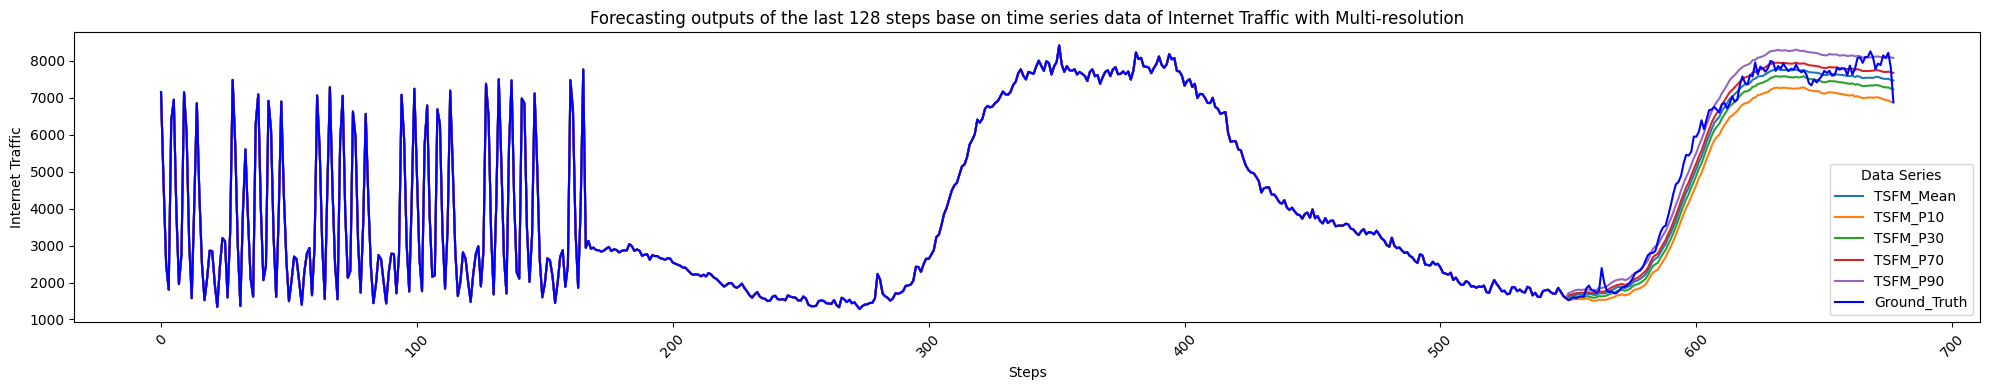

In [9]:
# Select columns to plot
df_plot_final = df_plot[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']]
plt.figure(figsize=(20, 4)) 
ax = df_plot_final.plot(ax=plt.gca(), title='Forecasting outputs of the last 128 steps base on time series data of Internet Traffic with Multi-resolution', grid=True)
# Add the plot of ground truth on the top
df_plot['Ground_Truth'].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('Internet Traffic')
ax.legend(title='Data Series')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

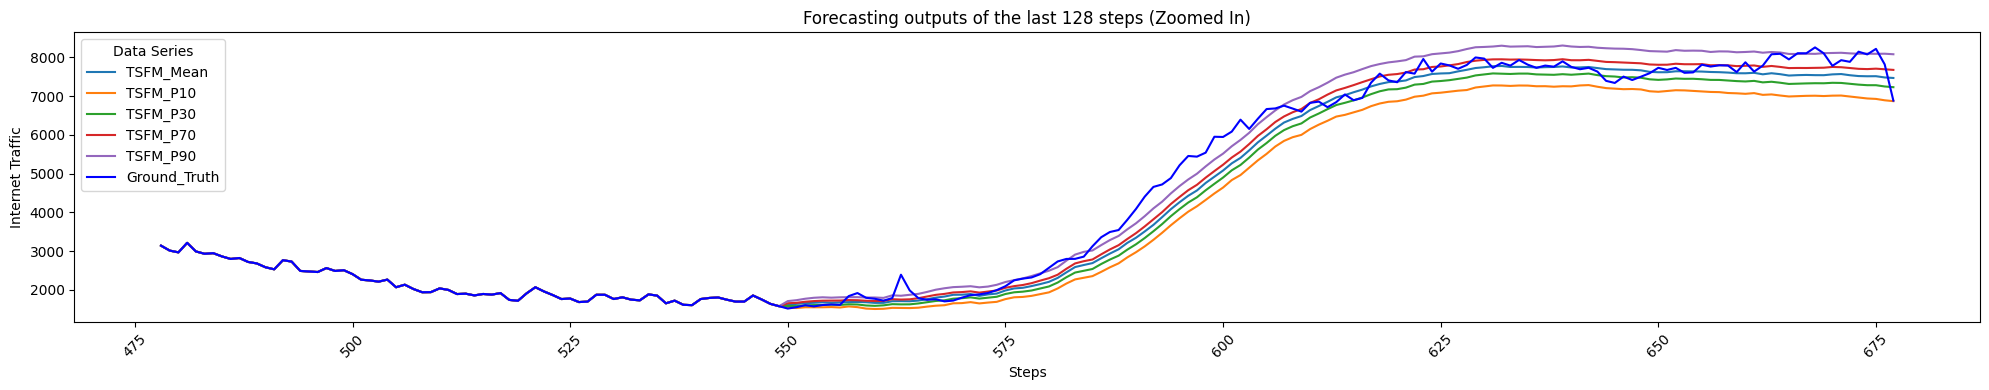

In [10]:
# Zoom in to the last 200 steps
df_plot_final = df_plot[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']][-200:]
plt.figure(figsize=(20, 4)) 
ax = df_plot_final.plot(ax=plt.gca(), title='Forecasting outputs of the last 128 steps (Zoomed In)', grid=True)
df_plot['Ground_Truth'][-200:].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('Internet Traffic')
ax.legend(title='Data Series')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
# Stage 6: Forecasting on Future States

To forecast the future states, we use the model to forecast the next 128 steps into the future.

In [11]:
future_forecasts = model.forecast([df["bits_transferred"].tolist()], horizon_len=128)

In [12]:
print("Mean: " + str(future_forecasts[0]["mean"].shape))
print("Quantile 0.1: " + str(future_forecasts[0]["quantiles"]["0.1"].shape))

Mean: (128,)
Quantile 0.1: (128,)


In [13]:
# Padding Ground-truth series
ground_truth_future = processed_series.copy()
ground_truth_future.extend(["N/A"]*128)

# Obtain mean and quantiles of the forecasted series
means_future = processed_series + future_forecasts[0]["mean"].tolist()
p10_future = processed_series + future_forecasts[0]["quantiles"]["0.1"].tolist() 
p20_future = processed_series + future_forecasts[0]["quantiles"]["0.2"].tolist() 
p30_future = processed_series + future_forecasts[0]["quantiles"]["0.3"].tolist() 
p40_future = processed_series + future_forecasts[0]["quantiles"]["0.4"].tolist() 
p50_future = processed_series + future_forecasts[0]["quantiles"]["0.5"].tolist() 
p60_future = processed_series + future_forecasts[0]["quantiles"]["0.6"].tolist() 
p70_future = processed_series + future_forecasts[0]["quantiles"]["0.7"].tolist() 
p80_future = processed_series + future_forecasts[0]["quantiles"]["0.8"].tolist() 
p90_future = processed_series + future_forecasts[0]["quantiles"]["0.9"].tolist() 

# Put all results into a dataframe
df_plot_future = pd.DataFrame({
    'Steps': list(range(len(ground_truth_future))),
    'Ground_Truth': ground_truth_future,
    'TSFM_Mean': means_future,
    'TSFM_P10': p10_future,
    'TSFM_P20': p20_future,
    'TSFM_P30': p30_future,
    'TSFM_P40': p40_future,
    'TSFM_P50': p50_future,
    'TSFM_P60': p60_future,
    'TSFM_P70': p70_future,
    'TSFM_P80': p80_future,
    'TSFM_P90': p90_future,
})

df_plot_future.set_index('Steps')

,Ground_Truth,TSFM_Mean,TSFM_P10,TSFM_P20,TSFM_P30,TSFM_P40,TSFM_P50,TSFM_P60,TSFM_P70,TSFM_P80,TSFM_P90
Steps,,,,,,,,,,,
0,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162,7154.258162
1,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228,4686.673228
2,2489.88836,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360,2489.888360
3,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715,1807.256715
4,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652,6389.501652
...,...,...,...,...,...,...,...,...,...,...,...
801,N/A,1903.776123,1680.453125,1768.119873,1820.241943,1859.988281,1893.919434,1928.613281,1969.673828,2021.577637,2096.380615
802,N/A,1896.060059,1663.219727,1749.821045,1805.701660,1846.603027,1880.854248,1921.615234,1959.656982,2007.720947,2093.351318
803,N/A,1916.559814,1687.608154,1776.236816,1831.436279,1877.222412,1913.194580,1953.246582,1991.752441,2039.438477,2126.448486


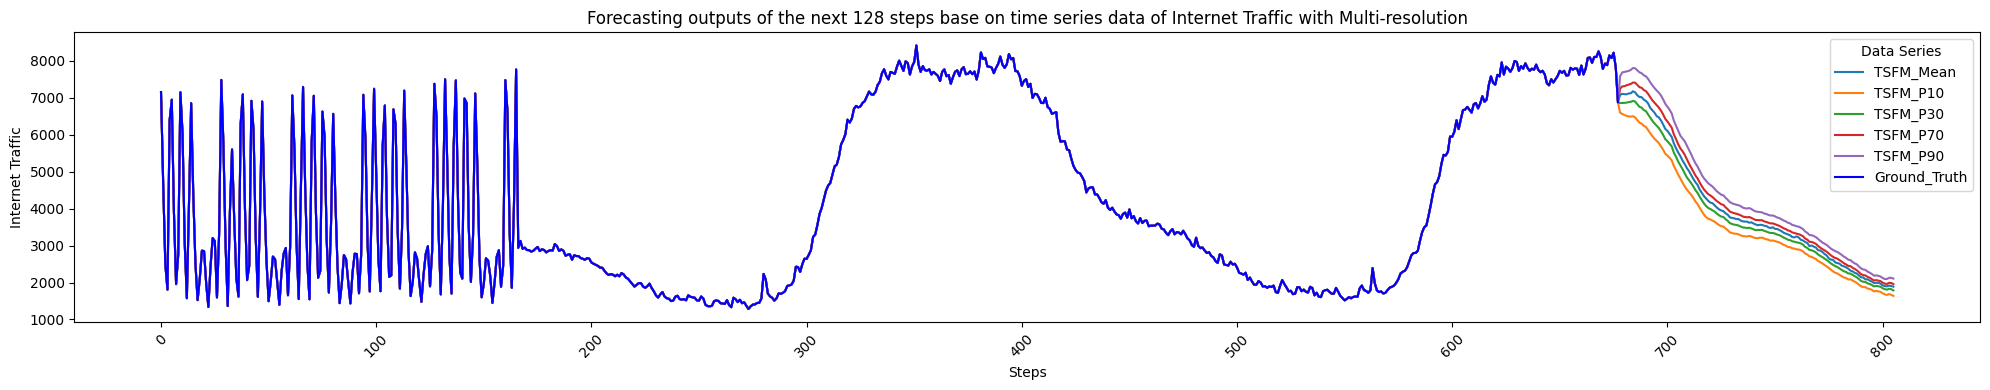

In [14]:
# Select columns to plot
df_plot_future_final = df_plot_future[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']]
plt.figure(figsize=(20, 4)) 
ax = df_plot_future_final.plot(ax=plt.gca(), title='Forecasting outputs of the next 128 steps base on time series data of Internet Traffic with Multi-resolution', grid=True)
# Add the plot of ground truth on the top
df_plot_future['Ground_Truth'][:-128].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('Internet Traffic')
ax.legend(title='Data Series')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

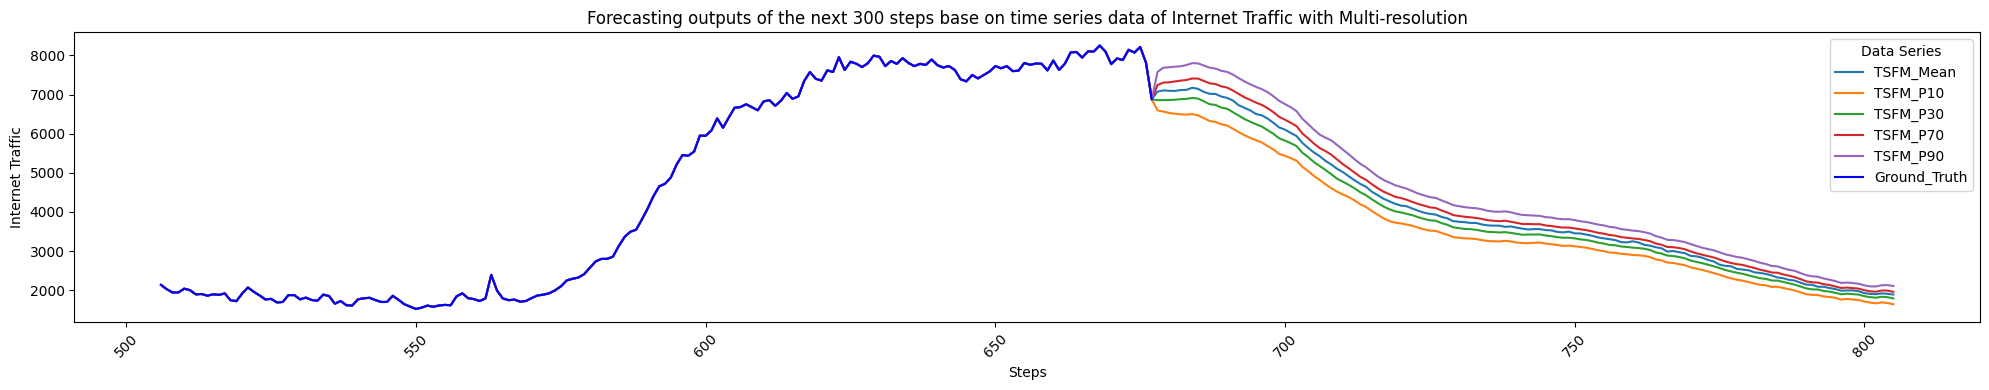

In [15]:
# Zoom in to the last 300 steps
df_plot_future_final = df_plot_future[['TSFM_Mean', 'TSFM_P10', 'TSFM_P30', 'TSFM_P70', 'TSFM_P90']][-300:]
plt.figure(figsize=(20, 4)) 
ax = df_plot_future_final.plot(ax=plt.gca(), title='Forecasting outputs of the next 300 steps base on time series data of Internet Traffic with Multi-resolution', grid=True)
# Add the plot of ground truth on the top
df_plot_future['Ground_Truth'][-300:][:-128].plot(ax=ax, color='blue', label='Ground_Truth')
plt.xlabel('Steps')
plt.ylabel('Internet Traffic')
ax.legend(title='Data Series')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()